In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from sklearn.cluster import KMeans
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta
import yfinance as yf
import seaborn as sns
sns.set(style='darkgrid')
from kneed import KneeLocator
from sklearn.metrics import r2_score

import sys
sys.path.append('../src') 
from utils import stock_trading_strategy, stock_trading_strategy_supp_resist, plot_trading_strategy, download_stock_df, user_function, plot_candlestick

In [2]:
def get_optimum_clusters(df, saturation_point=0.05):
    '''

    :param df: dataframe
    :param saturation_point: The amount of difference we are willing to detect
    :return: clusters with optimum K centers

    This method uses elbow method to find the optimum number of K clusters
    We initialize different K-means with 1..10 centers and compare the inertias
    If the difference is no more than saturation_point, we choose that as K and move on
    '''

    wcss = []
    k_models = []

    size = min(11, len(df.index))
    for i in range(1, size):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
        k_models.append(kmeans)

    # Compare differences in inertias until it's no more than saturation_point
    optimum_k = len(wcss)-1
    for i in range(0, len(wcss)-1):
        diff = abs(wcss[i+1] - wcss[i])
        if diff < saturation_point:
            optimum_k = i
            break

    # knee = KneeLocator(range(1, size), wcss, curve='convex', direction='decreasing')
    # optimum_k = knee.knee

    # print("Optimum K is " + str(optimum_k + 1))
    optimum_clusters = k_models[optimum_k]

    return optimum_clusters

In [3]:
from dateutil.relativedelta import relativedelta
from math import ceil, floor

def test_option_trading(stock_name,
                        start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'),
                        end=datetime.today().strftime('%Y-%m-%d'),
                        return_result=False,
                       ):

    # Step 0: download the stock
    df = yf.download(stock_name.upper(), start=start, end=end)
                     
    df = df.reset_index()
    
    print(datetime.today().strftime('%Y-%m-%d'))

    # Step 1: Moving average and Bollinger Band
    
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['50 Day MA'] = df['Close'].rolling(window=50).mean()
    df['50 Day STD'] = df['Close'].rolling(window=50).std()
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
    # Step 2: calculate RSI

    


    # Step 3: Support and resistance calculation, using clustering
    
    df_plot = df[df['Date'] >= df['Date'].min() + relativedelta(years=1)]

    low_clusters = get_optimum_clusters(df_plot[(df_plot['Low']!=df_plot['Open'])&(df_plot['Low']!=df_plot['Close'])][['Date',"Low"]].set_index('Date'))
    # low_clusters = get_optimum_clusters(df_plot[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df_plot[(df_plot['High']!=df_plot['Open'])&(df_plot['High']!=df_plot['Close'])][['Date',"High"]].set_index('Date'))
    # high_clusters = get_optimum_clusters(df_plot[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df_plot.iloc[-1]['Close']
    try: 
        support = max([e[0] for e in low_centers if e < close])
    except:
        print('Break all support; record min stock price')
        support = df_plot['Low'].min()
    try:
        resistance = min([e[0] for e in high_centers if e > close])
    except:
        print('Break all resistance; record max stock price')
        resistance = df_plot['High'].max()

    # Finally, output and plot 
    
    close = df_plot.iloc[-1]['Close']
    print('* previous stock price closing', round(close,2), '~ up', ceil(resistance*100)/100.0, ', down', floor(support*100)/100)
    print("Latest 20 Day MA:", df_plot['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band, 20MA:", df_plot['Lower Band - 20MA'].tolist()[-1])
    print("Latest Higher Bollinger Band, 20MA:", df_plot['Upper Band - 20MA'].tolist()[-1])
    print("Latest 50 Day MA:", df_plot['50 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band, 50MA:", df_plot['Lower Band - 50MA'].tolist()[-1])
    print("Latest Higher Bollinger Band, 50MA:", df_plot['Upper Band - 50MA'].tolist()[-1])
    print(low_centers)
    print(high_centers)
    
    ax = plot_candlestick(df_plot, figsize=(32,8))
    ax.set_title(stock_name)
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')
    # df_plot['5_MA'] = df_plot['Close'].rolling(window=5).mean()
    # df_plot['9_MA'] = df_plot['Close'].rolling(window=9).mean()
    # df_plot['20_MA'] = df_plot['Close'].rolling(window=20).mean()
    # df_plot['50_MA'] = df_plot['Close'].rolling(window=50).mean()

    # ax.plot(df_plot['Date'], df_plot['Close'], color='black')
    # ax.plot(df_plot['Date'], df_plot['5_MA'], ls='--')

    # ax.plot(df_plot['Date'], df_plot['9_MA'], ls='--')
    # ax.plot(df_plot['Date'], df_plot['20_MA'], ls='--')
    # ax.plot(df_plot['Date'], df_plot['50_MA'], ls='--')
    ax.plot(df_plot['Date'], df_plot['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df_plot['Date'], df_plot['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
    ax.plot(df_plot['Date'], df_plot['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
    ax.fill_between(df_plot['Date'], df_plot['Upper Band - 20MA'], df_plot['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
    ax.plot(df_plot['Date'], df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
    ax.plot(df_plot['Date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
    ax.plot(df_plot['Date'], df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
    ax.fill_between(df_plot['Date'], df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands

    if return_result:
        return df_plot

## Test effectiveness of support and resistance in option trading

### Strategy 1:
* Touch support: long call
* Touch resistance: long put

#### Fail

### Strategy 2:

* Touch support
    * reflect: long call
    * break: long put
* Touch resistance:
    * reflect: long put
    * break: long call
    
#### Key question: how to confirm break / reflect?

* Base assumption: assume the support and resistance to hold, unless strong conflict signal observed.
* Assumption1.1: when going down, a short red line / long green line confirm reflect; long red line confirm break
* Assumption1.2: when going up, a short green line / long red line confirm reflect; long green line confirm break
* ~~Read from 1-min Candlestick~~ -- not applicable
* Check if trend is align with QQQ/SPY


#### Stop revenue needed; for conservative, start with 20%.

#### Precision of level should be relative to the stock price.

#### Hard to validate/'

### Strategy 3: 

* Touch support / resistance: check with the daily price range, 95% confidence

QQQ & TQQQ

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 431.1 ~ up 442.89 , down 425.03
Latest 20 Day MA: 441.1240005493164
Latest Lower Bollinger Band, 20MA: 432.0596111307344
Latest Higher Bollinger Band, 20MA: 450.1883899678984
Latest 50 Day MA: 437.990400390625
Latest Lower Bollinger Band, 50MA: 424.0371318633114
Latest Higher Bollinger Band, 50MA: 451.94366891793857
[[317.7219986 ]
 [331.93249893]
 [347.65266724]
 [357.08562469]
 [365.85487248]
 [374.69266459]
 [387.31217359]
 [405.00347768]
 [425.03136375]
 [437.90341829]]
[[322.01714507]
 [336.72285679]
 [351.27333238]
 [359.4341685 ]
 [368.69425477]
 [377.2575852 ]
 [388.66370533]
 [407.68719971]
 [428.95636264]
 [442.88794963]]


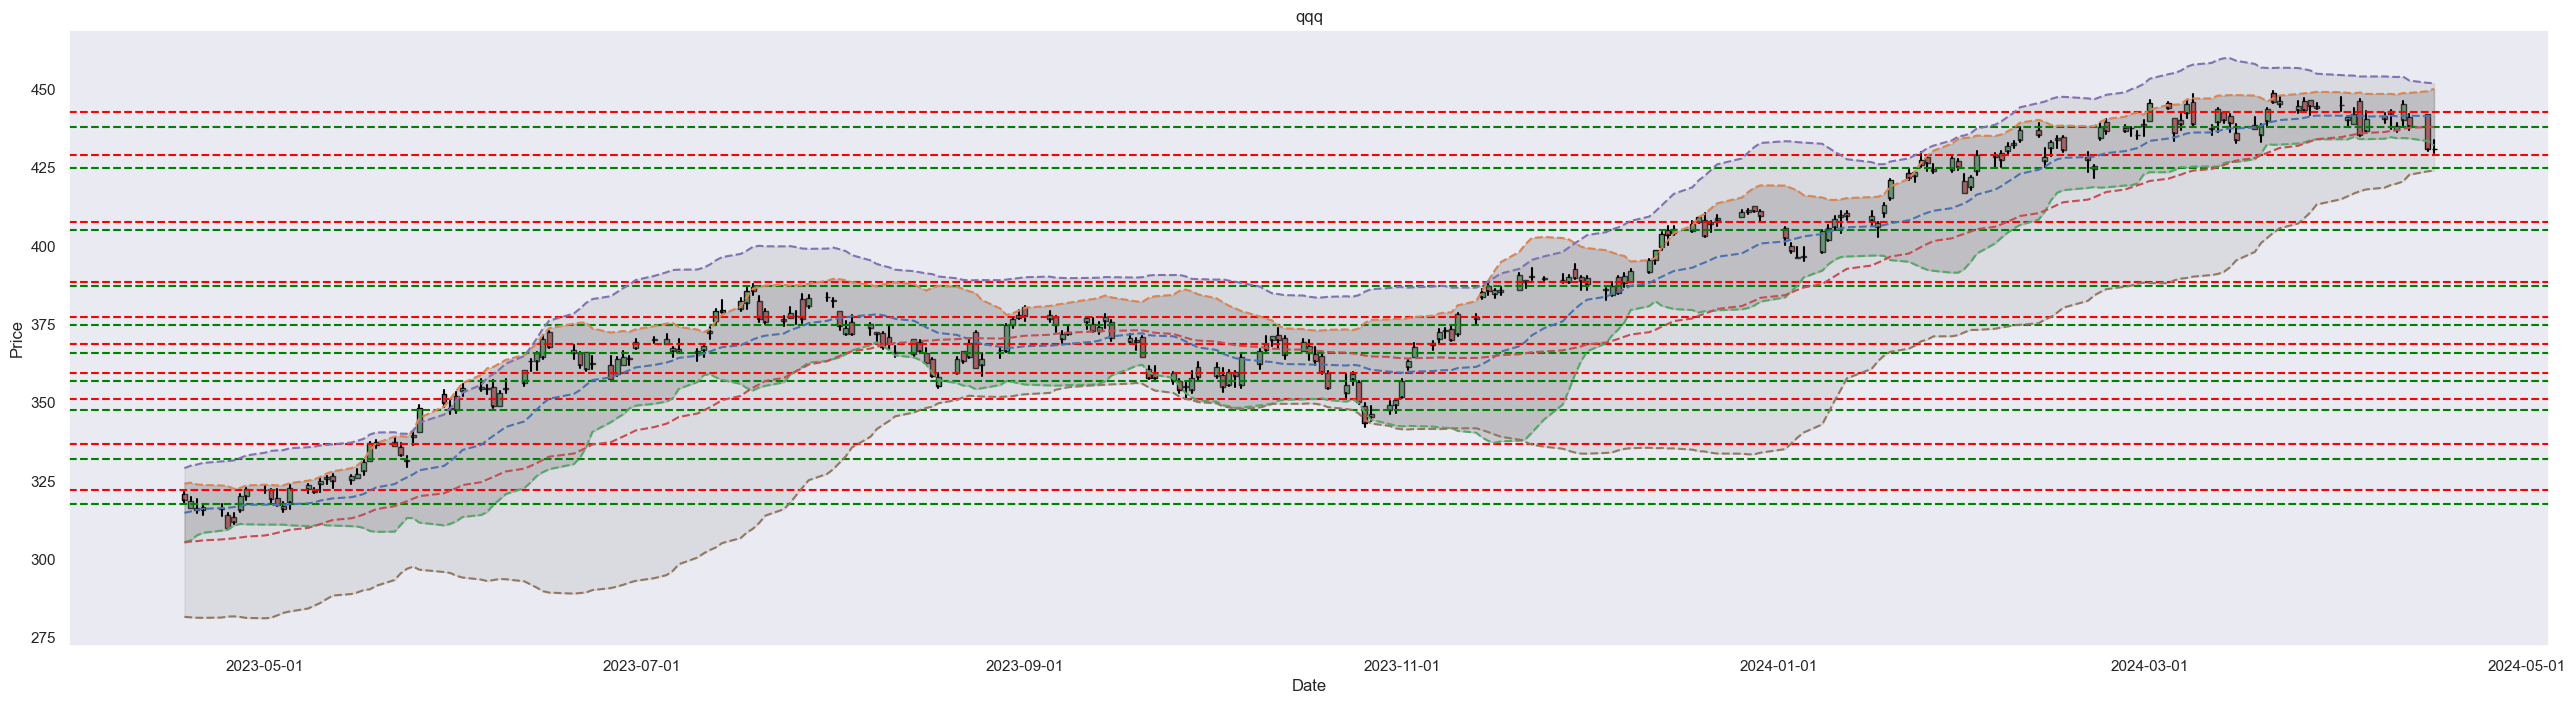

In [4]:
test_option_trading('qqq')

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 55.78 ~ up 56.57 , down 54.7
Latest 20 Day MA: 60.272000312805176
Latest Lower Bollinger Band, 20MA: 56.23186119055353
Latest Higher Bollinger Band, 20MA: 64.31213943505682
Latest 50 Day MA: 59.67500030517578
Latest Lower Bollinger Band, 50MA: 54.72270390768875
Latest Higher Bollinger Band, 50MA: 64.62729670266282
[[27.22954542]
 [31.63846207]
 [35.39457147]
 [38.64090893]
 [41.78176476]
 [44.58000011]
 [49.11499996]
 [54.7016663 ]
 [58.50687528]
 [61.25545467]]
[[28.1171429 ]
 [32.09454536]
 [36.42032242]
 [39.61809494]
 [42.40705883]
 [45.41620675]
 [50.55952381]
 [56.56470534]
 [60.24892793]
 [62.89266663]]


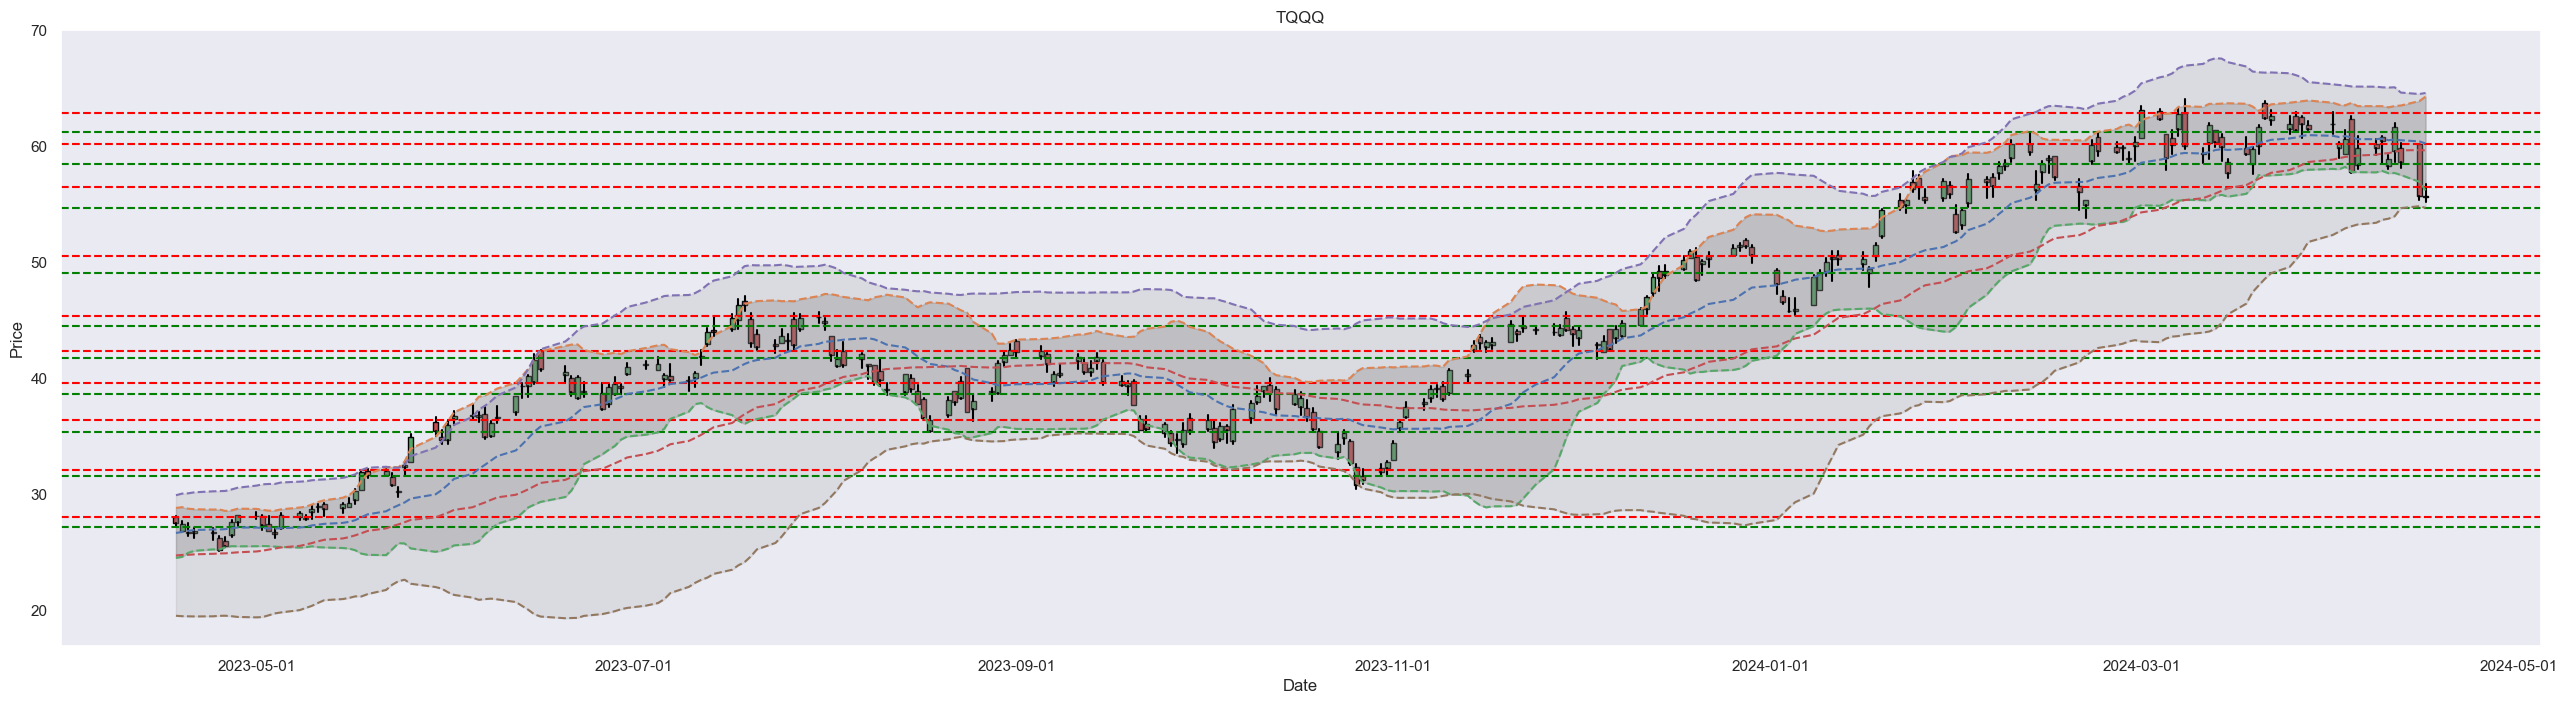

In [5]:
# 90% profit put: 53
test_option_trading('TQQQ')

SPY & UPRO

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 503.53 ~ up 510.12 , down 496.86
Latest 20 Day MA: 517.266000366211
Latest Lower Bollinger Band, 20MA: 506.1144529229795
Latest Higher Bollinger Band, 20MA: 528.4175478094423
Latest 50 Day MA: 510.229599609375
Latest Lower Bollinger Band, 50MA: 488.340747089573
Latest Higher Bollinger Band, 50MA: 532.118452129177
[[410.36483863]
 [422.01259133]
 [434.5080447 ]
 [445.739116  ]
 [453.98321206]
 [470.99920166]
 [486.38916779]
 [496.86999512]
 [508.62260901]
 [518.1499939 ]]
[[414.96588225]
 [428.12538616]
 [437.77676302]
 [447.69256514]
 [456.90580602]
 [474.65583547]
 [488.05999756]
 [498.78076876]
 [510.11307702]
 [519.6555957 ]]


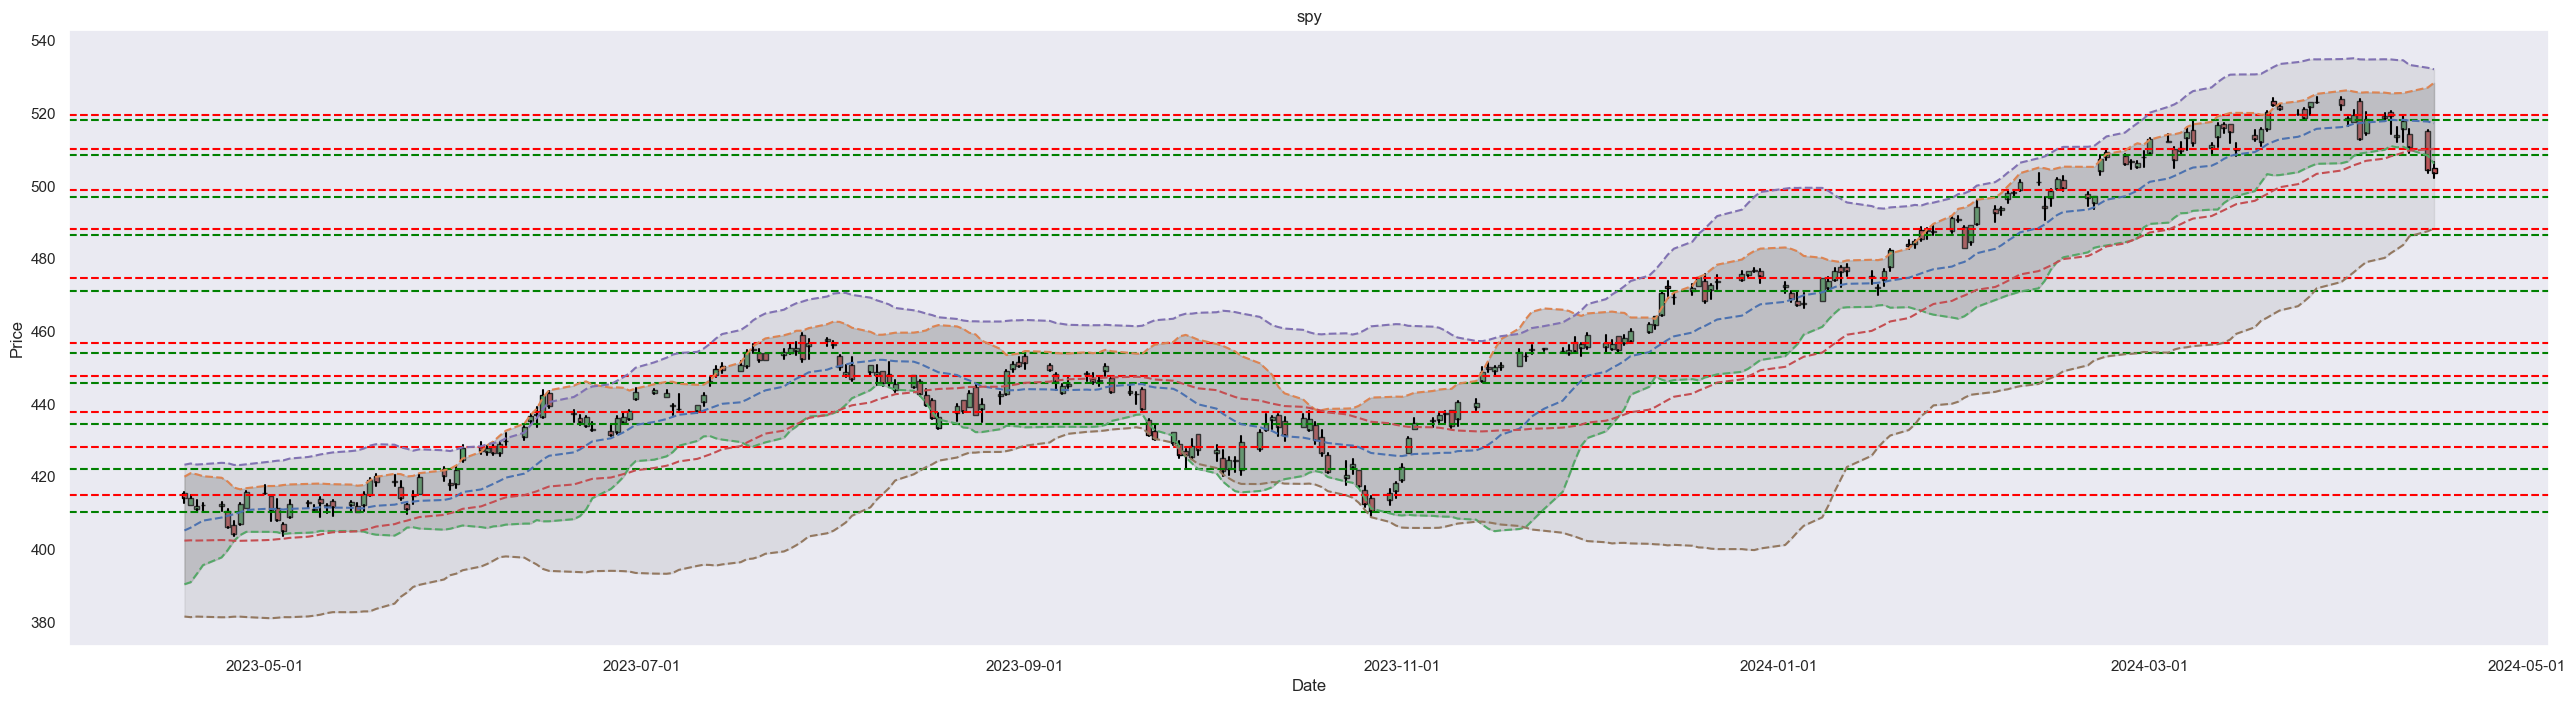

In [6]:
test_option_trading('spy')

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 62.37 ~ up 66.15 , down 58.42
Latest 20 Day MA: 68.12449913024902
Latest Lower Bollinger Band, 20MA: 63.382931202384
Latest Higher Bollinger Band, 20MA: 72.86606705811404
Latest 50 Day MA: 65.76619934082031
Latest Lower Bollinger Band, 50MA: 58.08354510507281
Latest Higher Bollinger Band, 50MA: 73.44885357656781
[[38.26860454]
 [41.8530307 ]
 [45.0721209 ]
 [47.54609764]
 [50.36133347]
 [53.49272693]
 [58.42250013]
 [62.69714301]
 [65.82499949]
 [69.0345452 ]]
[[39.3625    ]
 [43.02771443]
 [46.26093745]
 [48.44868419]
 [50.83333355]
 [54.46416696]
 [58.58199997]
 [62.08500017]
 [66.14199931]
 [69.39227295]]


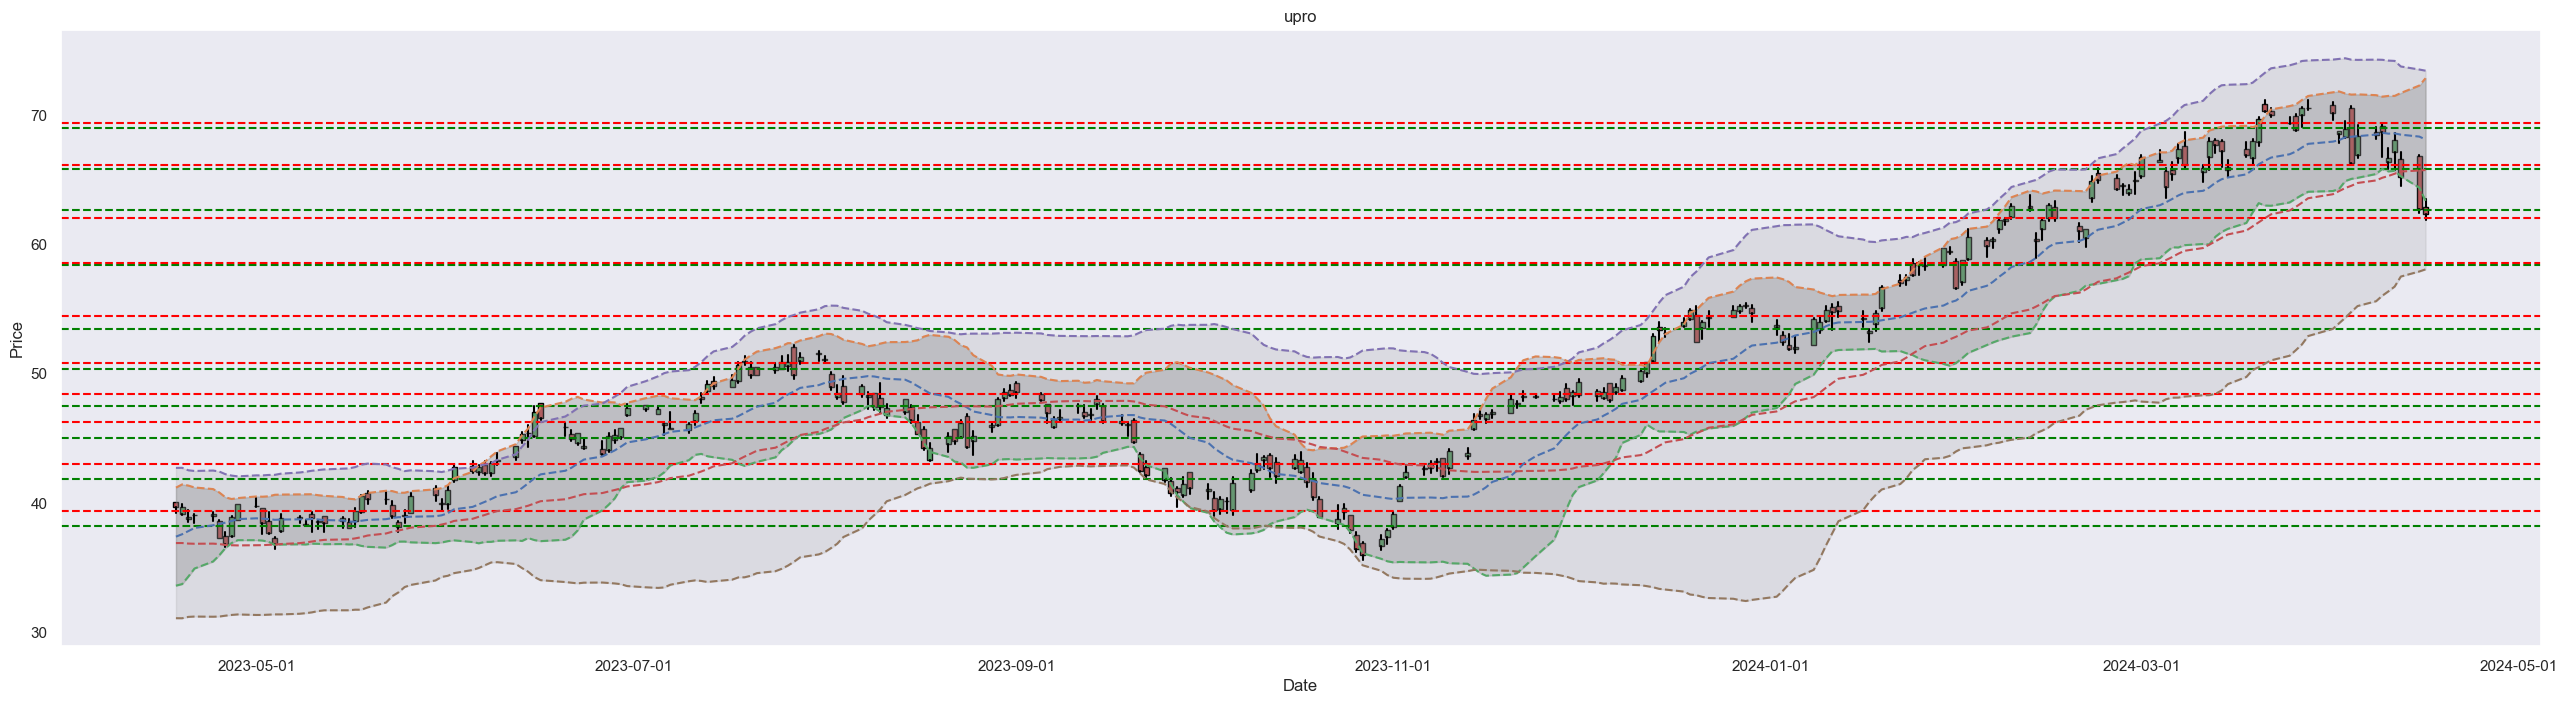

In [7]:
# 90% profit put: 60
test_option_trading('upro')

SOXX & SOXL

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 216.94 ~ up 225.05 , down 211.55
Latest 20 Day MA: 222.45550003051758
Latest Lower Bollinger Band, 20MA: 215.072853889971
Latest Higher Bollinger Band, 20MA: 229.83814617106418
Latest 50 Day MA: 218.3060659790039
Latest Lower Bollinger Band, 50MA: 196.32700149444503
Latest Higher Bollinger Band, 50MA: 240.28513046356278
[[136.3963485 ]
 [146.05472056]
 [156.01120461]
 [162.29016337]
 [169.80449007]
 [181.33333435]
 [191.25666809]
 [200.49066569]
 [211.55357143]
 [222.21036897]]
[[139.35803084]
 [152.26066818]
 [162.31679932]
 [170.27944438]
 [177.81150055]
 [190.10650253]
 [202.92395782]
 [214.02047621]
 [225.04105863]
 [232.76708412]]


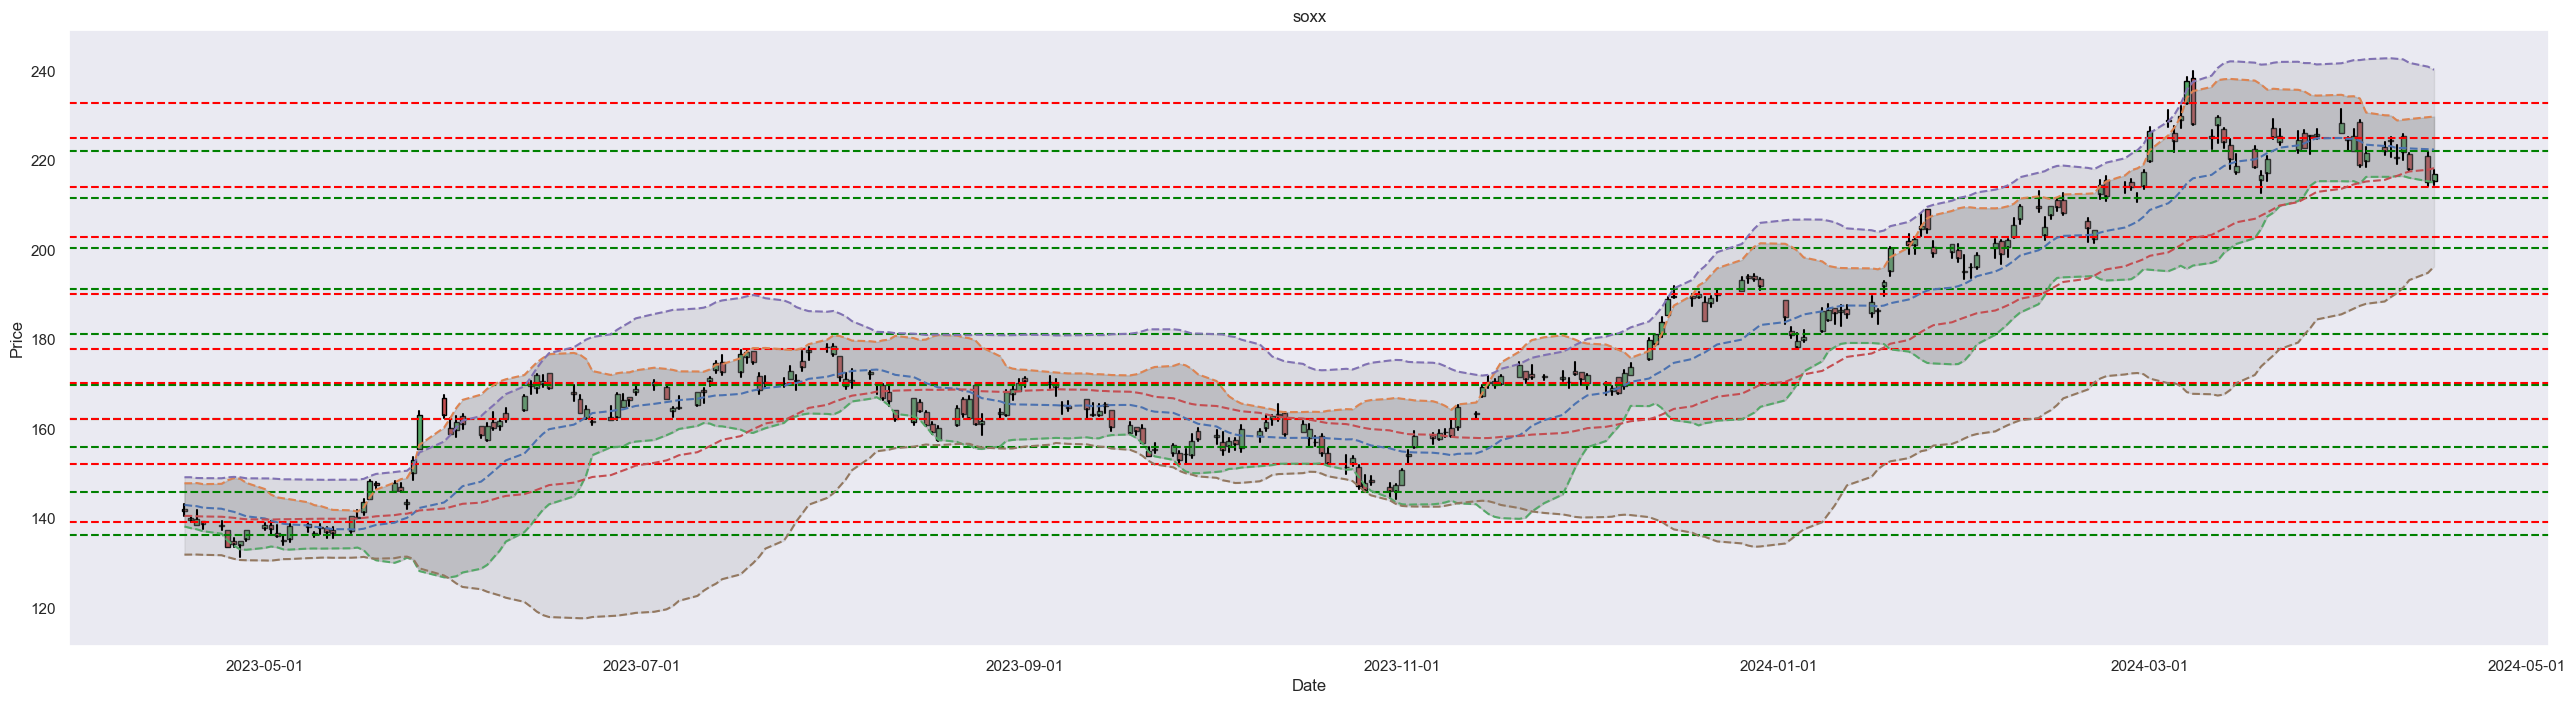

In [8]:
test_option_trading("soxx")

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 40.54 ~ up 44.76 , down 40.2
Latest 20 Day MA: 44.383499717712404
Latest Lower Bollinger Band, 20MA: 39.75789393500592
Latest Higher Bollinger Band, 20MA: 49.00910550041889
Latest 50 Day MA: 43.01520004272461
Latest Lower Bollinger Band, 50MA: 31.659076216549686
Latest Higher Bollinger Band, 50MA: 54.37132386889953
[[14.21733335]
 [17.93175001]
 [21.27297872]
 [23.70684207]
 [26.7962501 ]
 [30.92733307]
 [34.68357113]
 [40.20285706]
 [44.73999988]
 [49.65499973]]
[[15.06703709]
 [19.02775002]
 [22.6427659 ]
 [25.30560987]
 [29.3592307 ]
 [34.5299999 ]
 [40.16874957]
 [44.75933304]
 [48.7       ]
 [56.52500153]]


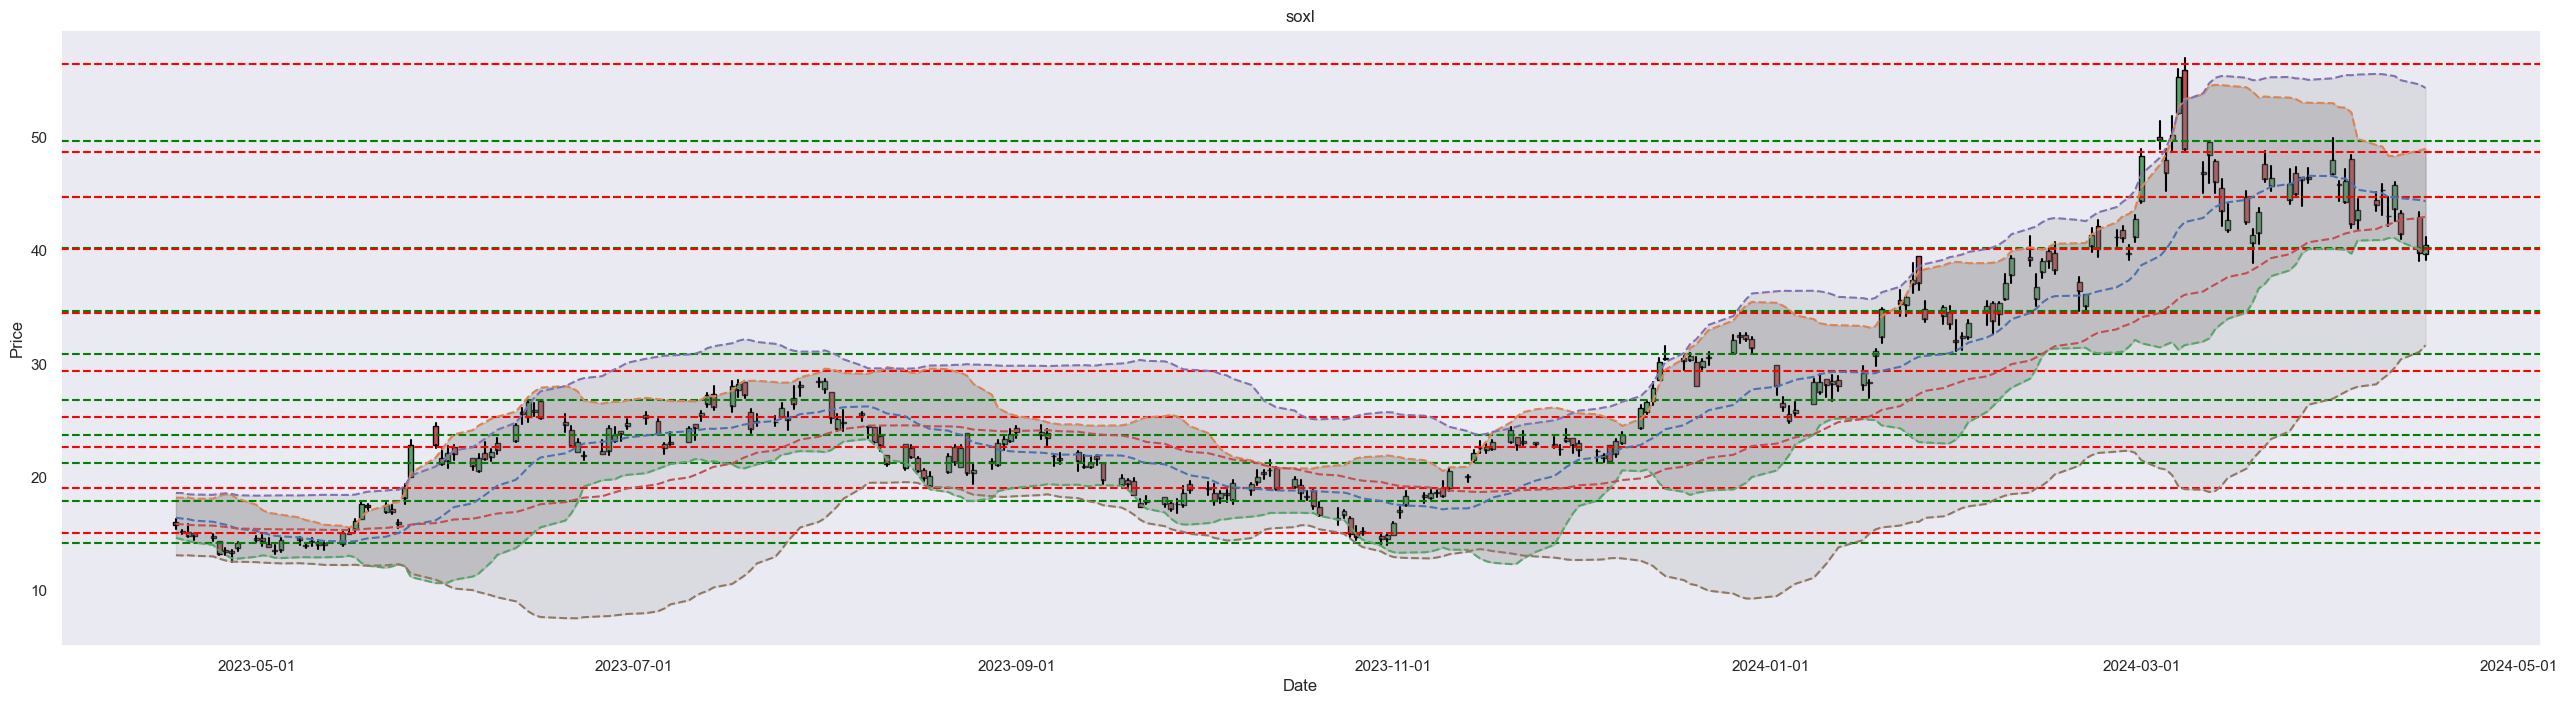

In [9]:
# 90% profit put: 36
test_option_trading("soxl")

NVDA & NVDL

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 874.15 ~ up 894.94 , down 857.63
Latest 20 Day MA: 894.0494995117188
Latest Lower Bollinger Band, 20MA: 841.1740619220153
Latest Higher Bollinger Band, 20MA: 946.9249371014222
Latest 50 Day MA: 833.0217993164063
Latest Lower Bollinger Band, 50MA: 628.6217395536125
Latest Higher Bollinger Band, 50MA: 1037.4218590792
[[281.56814462]
 [405.95245073]
 [444.61981855]
 [478.83555637]
 [545.05125427]
 [608.22299805]
 [693.71916707]
 [774.80999756]
 [857.63899536]
 [899.4827215 ]]
[[289.73740641]
 [423.60131186]
 [463.15384439]
 [493.22119068]
 [557.35286168]
 [622.8490878 ]
 [719.97332764]
 [803.31143624]
 [894.93142555]
 [940.56399536]]


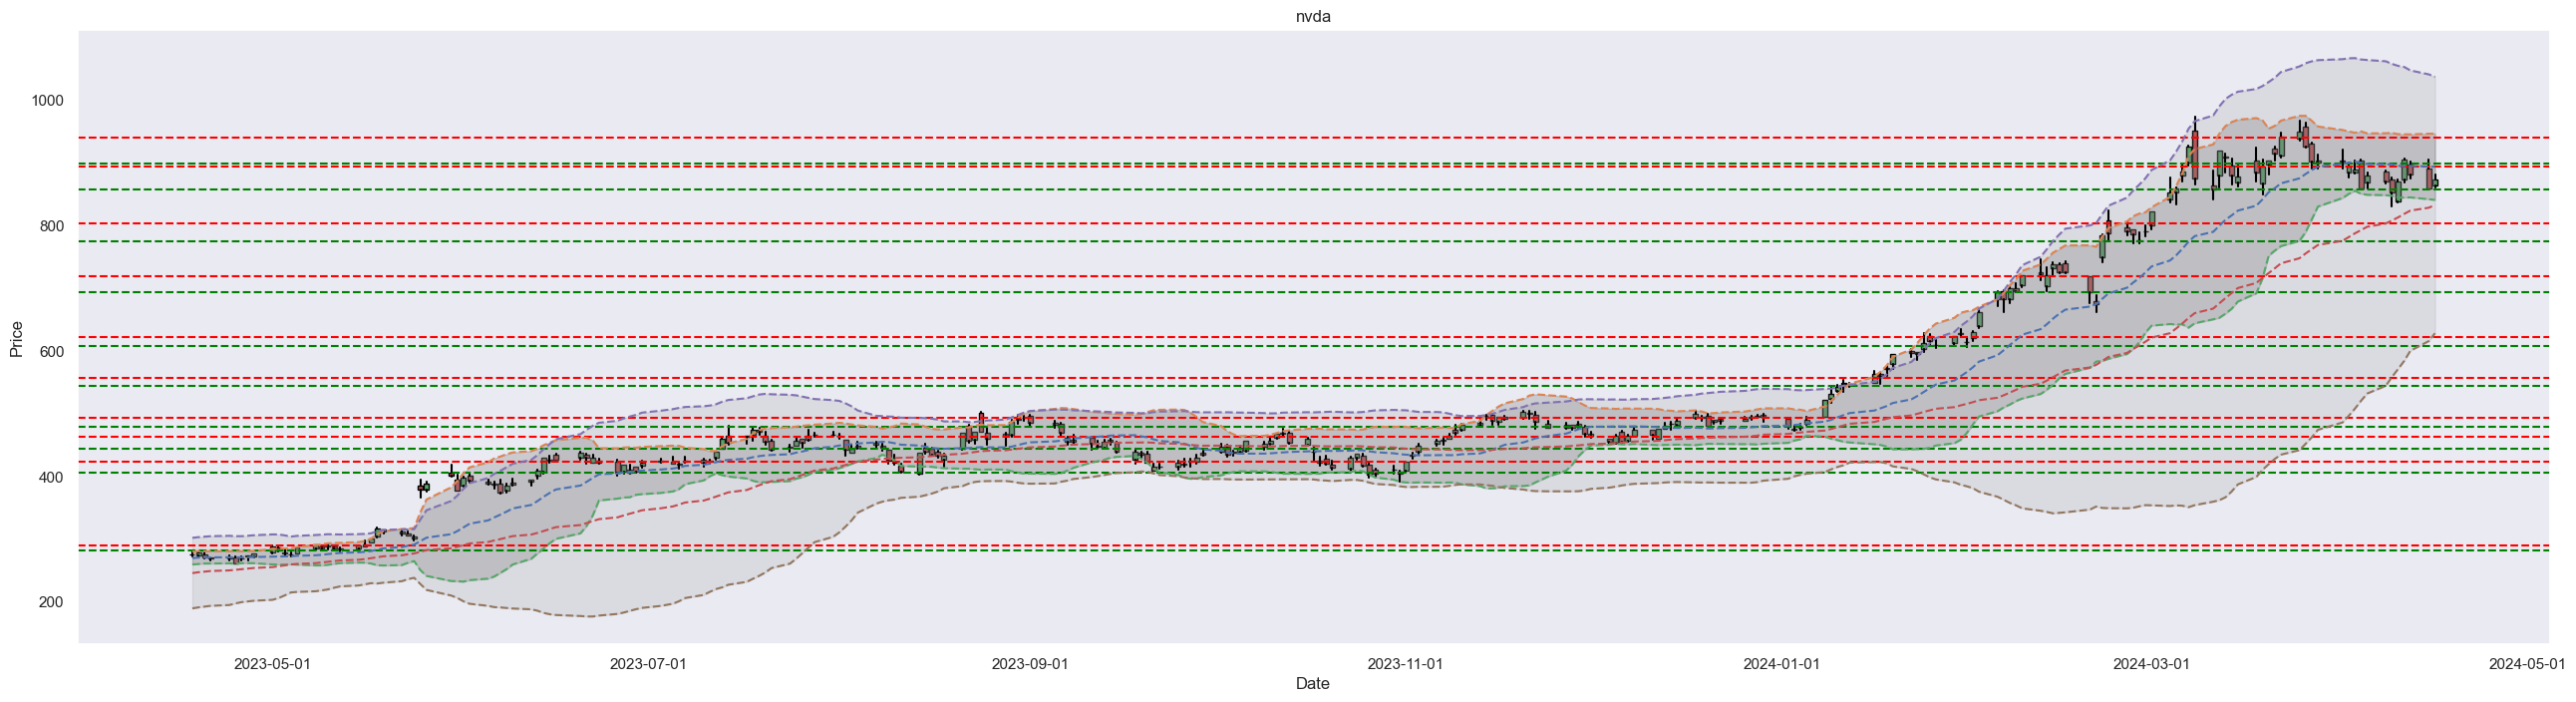

In [10]:
test_option_trading('nvda')

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 38.44 ~ up 39.3 , down 38.27
Latest 20 Day MA: 40.67900009155274
Latest Lower Bollinger Band, 20MA: 35.46698194711211
Latest Higher Bollinger Band, 20MA: 45.891018235993364
Latest 50 Day MA: 36.34479995727539
Latest Lower Bollinger Band, 50MA: 20.91187931834647
Latest Higher Bollinger Band, 50MA: 51.77772059620431
[[14.4341253 ]
 [16.64041668]
 [20.31798363]
 [24.33499985]
 [27.63852024]
 [31.99269485]
 [36.39619064]
 [38.27388859]
 [40.16285651]
 [42.89673309]]
[[14.81011908]
 [17.09785438]
 [21.13958359]
 [26.09458319]
 [29.28857177]
 [33.87278639]
 [39.29000037]
 [41.6387693 ]
 [43.88486099]
 [47.64100075]]


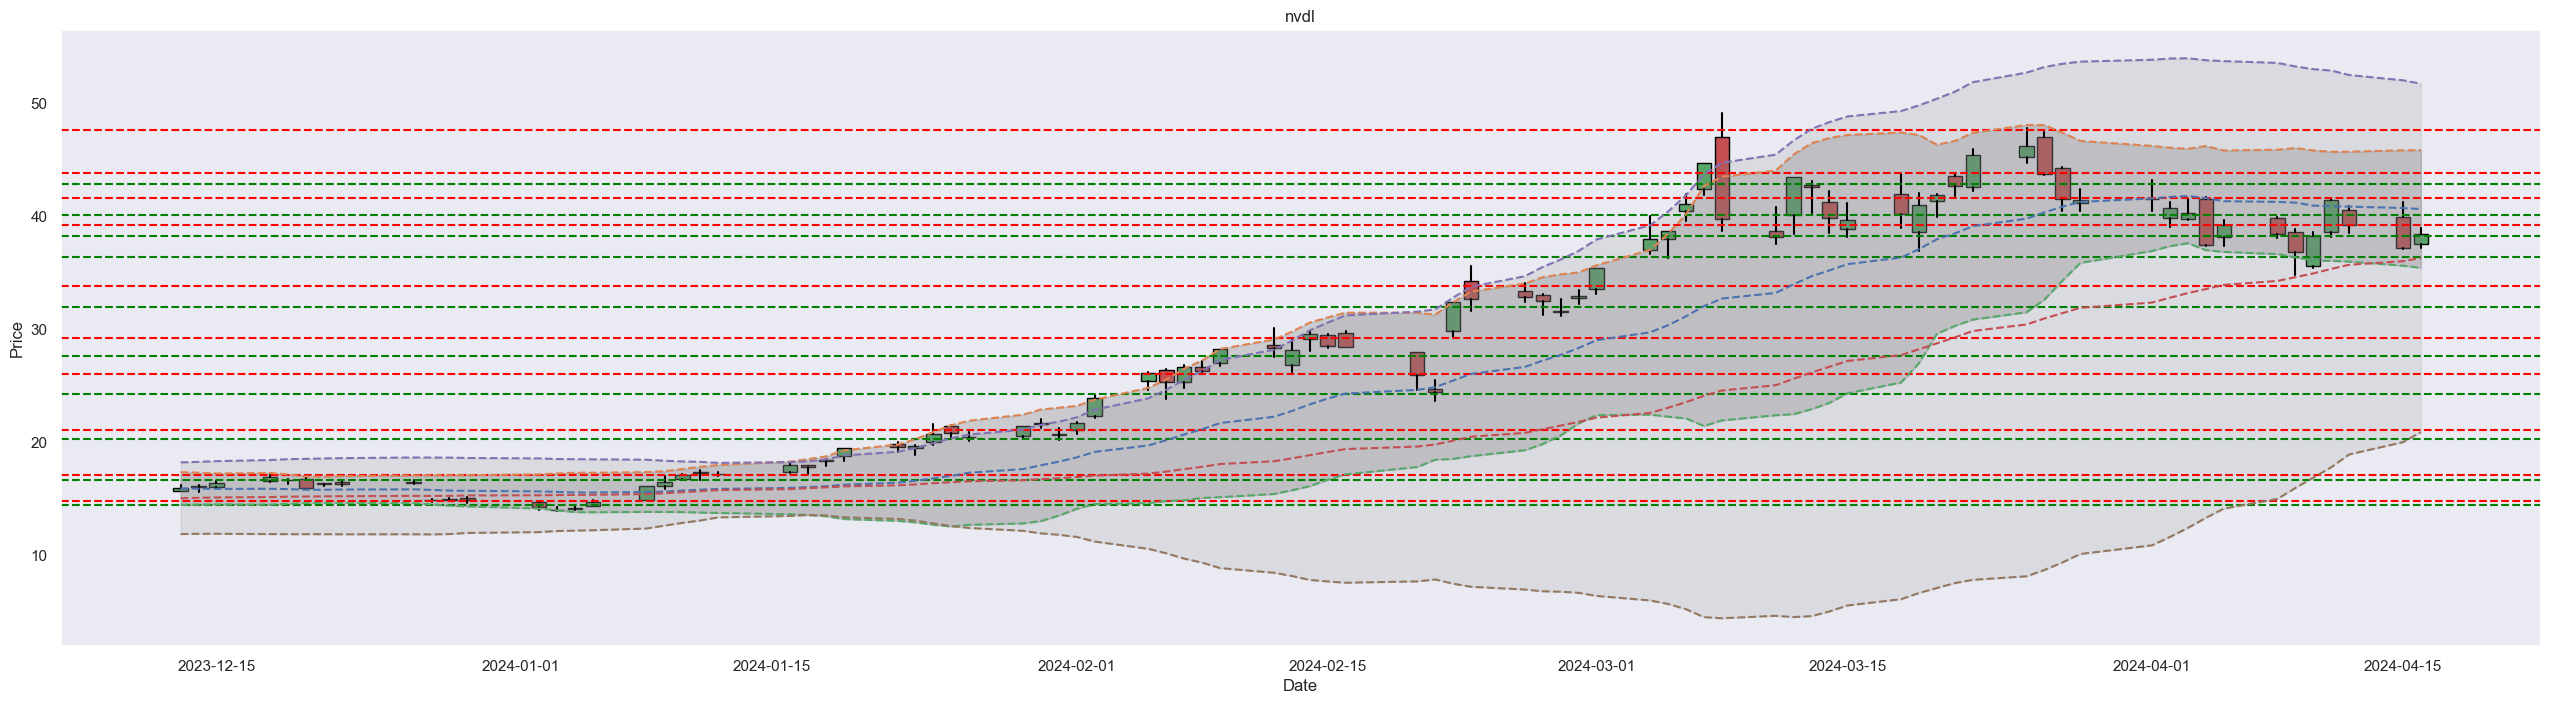

In [11]:
test_option_trading("nvdl")

Gld & UGL

[*********************100%%**********************]  1 of 1 completed
2024-04-17
Break all resistance; record max stock price
* previous stock price closing 221.22 ~ up 225.09 , down 215.94
Latest 20 Day MA: 210.12400131225587
Latest Lower Bollinger Band, 20MA: 194.8864953409434
Latest Higher Bollinger Band, 20MA: 225.36150728356833
Latest 50 Day MA: 199.3122006225586
Latest Lower Bollinger Band, 50MA: 171.43455740708538
Latest Higher Bollinger Band, 50MA: 227.18984383803183
[[170.01333449]
 [175.52882385]
 [178.18149986]
 [181.17622274]
 [183.85102609]
 [187.25686406]
 [189.90764842]
 [199.83117766]
 [209.63800049]
 [215.94142805]]
[[169.83600159]
 [174.7563643 ]
 [178.75565239]
 [181.95526244]
 [184.71809496]
 [188.39819736]
 [192.08333333]
 [201.6238895 ]
 [213.09833272]
 [220.76499939]]


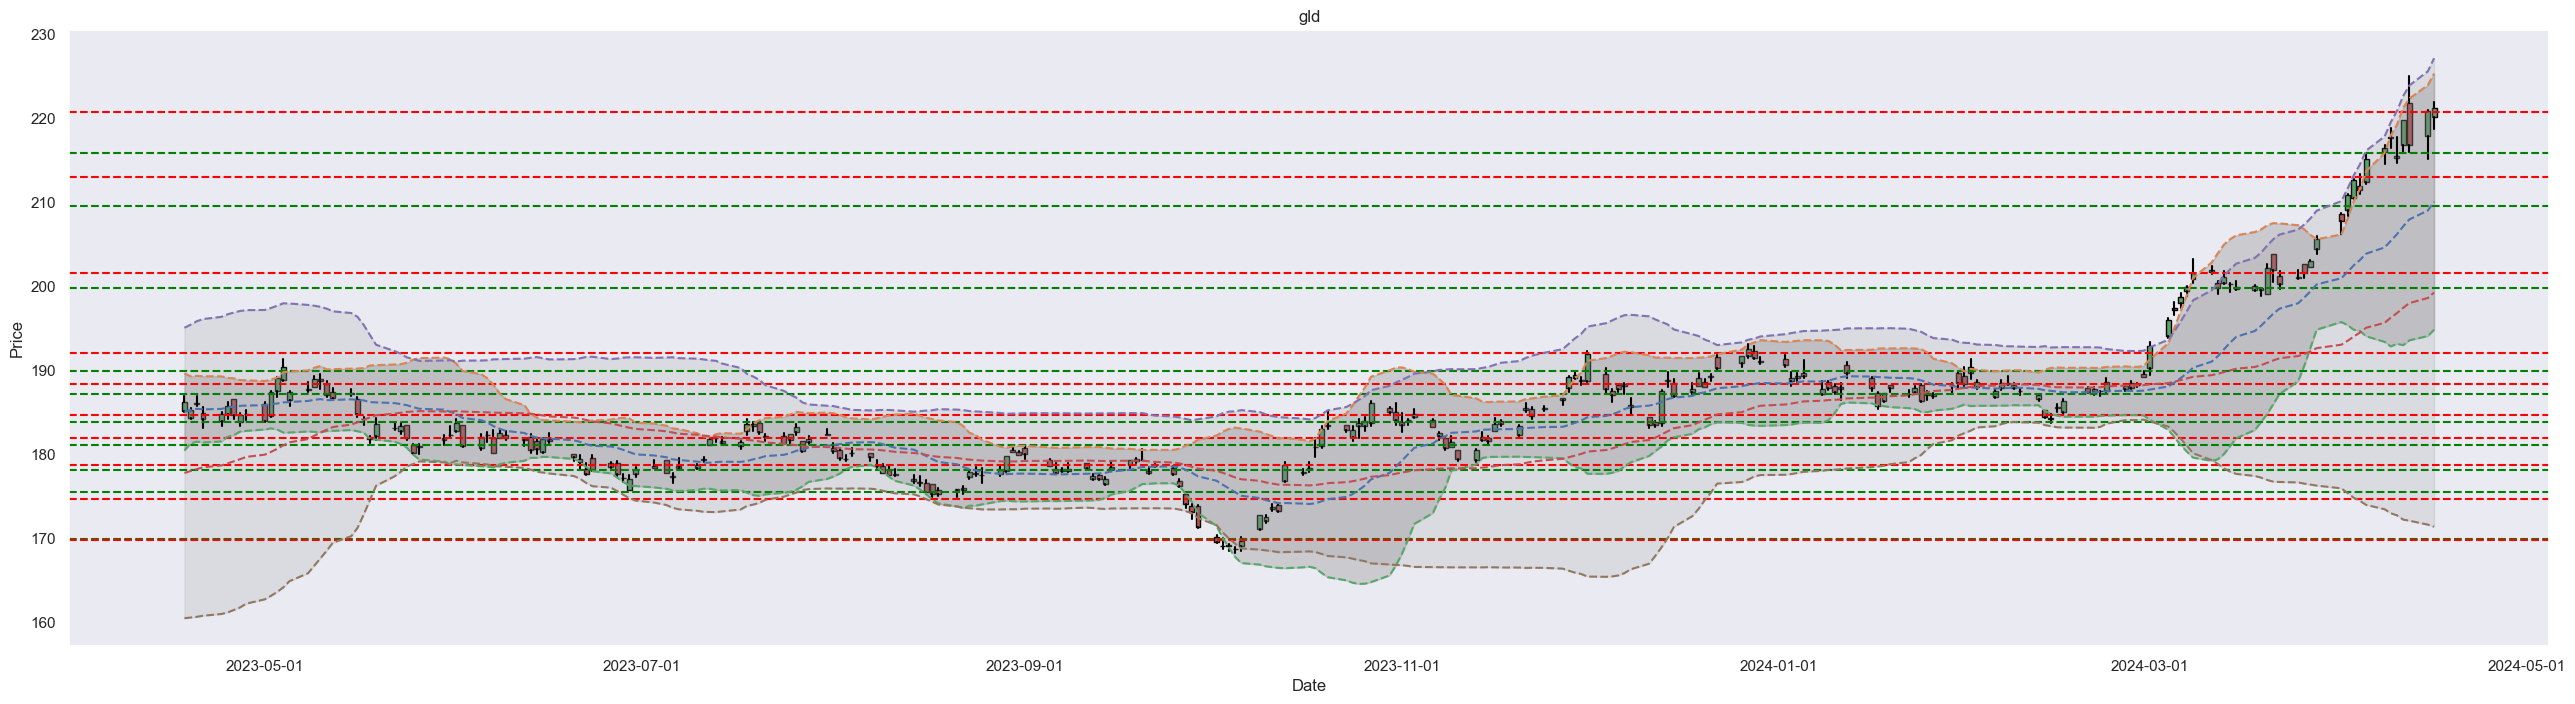

In [12]:
test_option_trading('gld')

[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 83.21 ~ up 84.29 , down 79.39
Latest 20 Day MA: 75.41300010681152
Latest Lower Bollinger Band, 20MA: 64.85279896924811
Latest Higher Bollinger Band, 20MA: 85.97320124437493
Latest 50 Day MA: 68.32019996643066
Latest Lower Bollinger Band, 50MA: 49.91339587335166
Latest Higher Bollinger Band, 50MA: 86.72700405950967
[[52.23416646]
 [56.65162174]
 [58.46894736]
 [60.1554902 ]
 [61.35833313]
 [63.0727272 ]
 [65.13538419]
 [68.66529442]
 [75.01800079]
 [79.39142827]]
[[52.86636422]
 [57.39857123]
 [59.27081082]
 [61.14062482]
 [62.87151556]
 [65.27250036]
 [69.42333306]
 [75.56800079]
 [80.81399841]
 [84.28999837]]


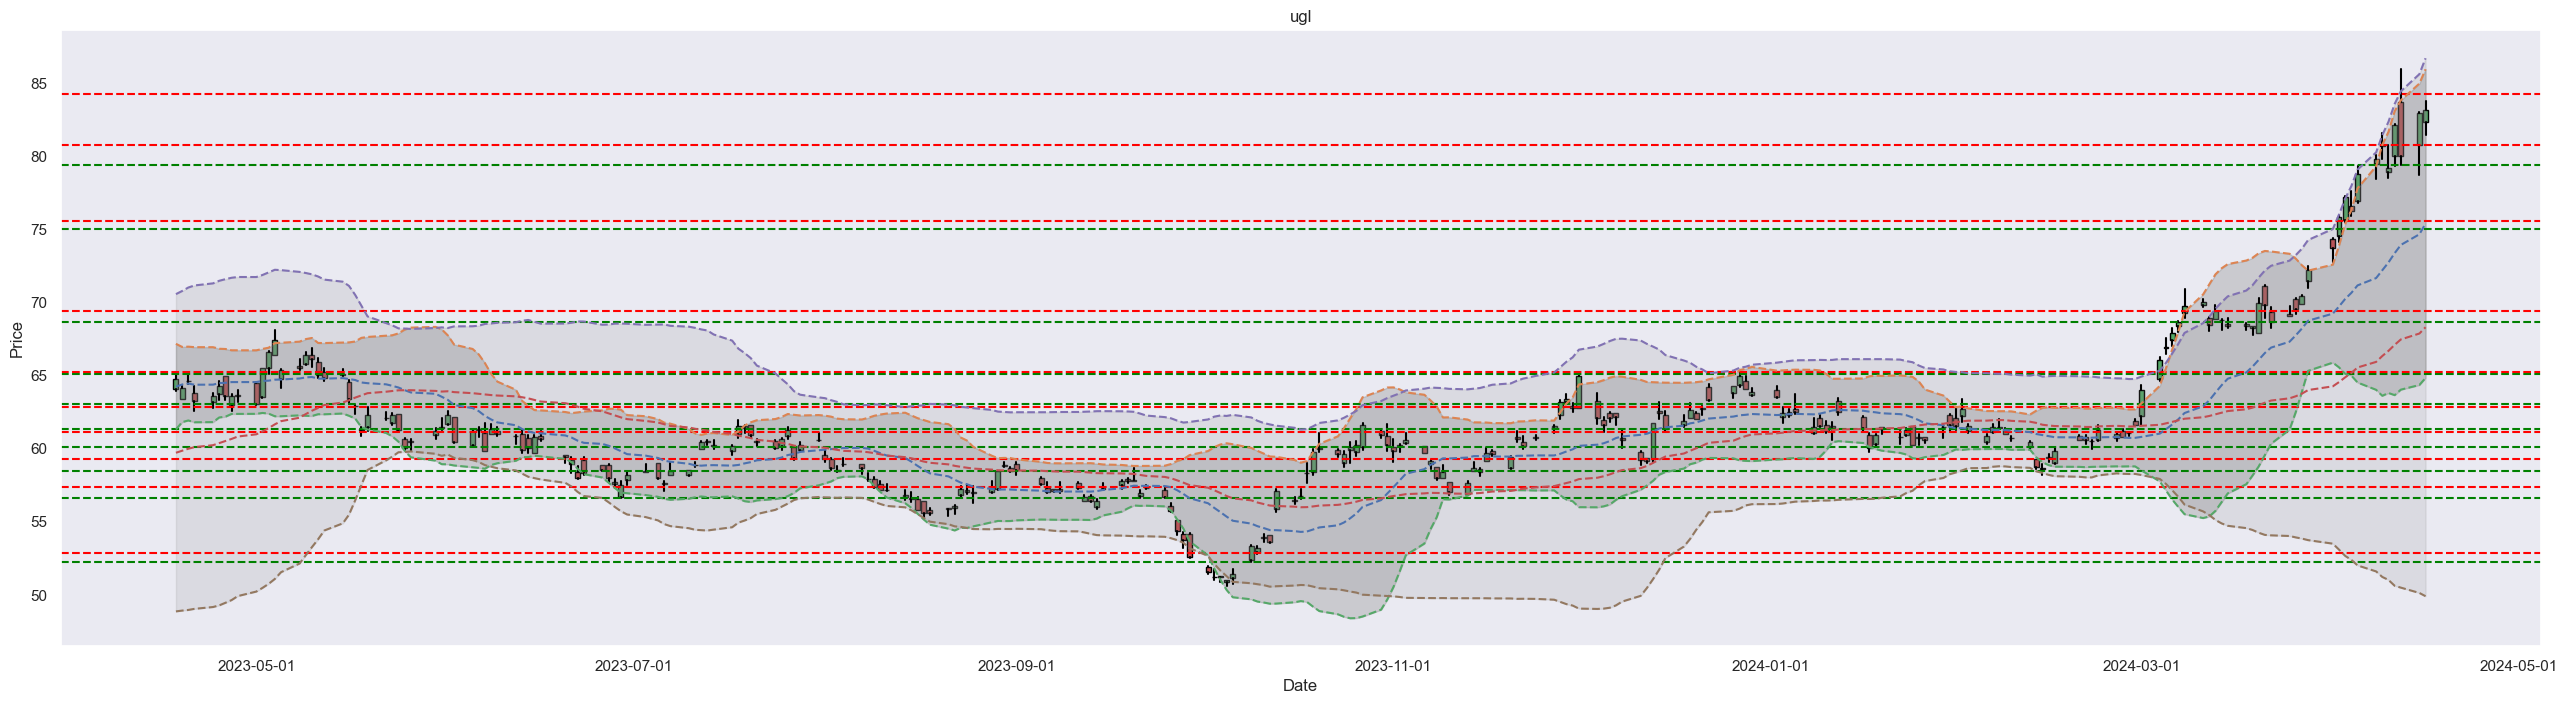

In [13]:
test_option_trading('ugl')

Random stocks

[*********************100%%**********************]  1 of 1 completed
2024-04-17
Break all support; record min stock price
* previous stock price closing 157.11 ~ up 166.59 , down 152.36
Latest 20 Day MA: 171.43250122070313
Latest Lower Bollinger Band, 20MA: 160.3247387790947
Latest Higher Bollinger Band, 20MA: 182.54026366231156
Latest 50 Day MA: 180.6890005493164
Latest Lower Bollinger Band, 50MA: 150.17459630465353
Latest Higher Bollinger Band, 50MA: 211.20340479397927
[[159.78190395]
 [170.09428406]
 [181.66583379]
 [194.85299911]
 [211.90535682]
 [230.9176651 ]
 [241.00968647]
 [250.76030338]
 [261.27652243]
 [276.52083333]]
[[166.58173868]
 [177.27259262]
 [188.84954487]
 [202.65350266]
 [219.70481477]
 [237.60961621]
 [247.61000061]
 [259.47217294]
 [273.94920044]
 [290.03000387]]


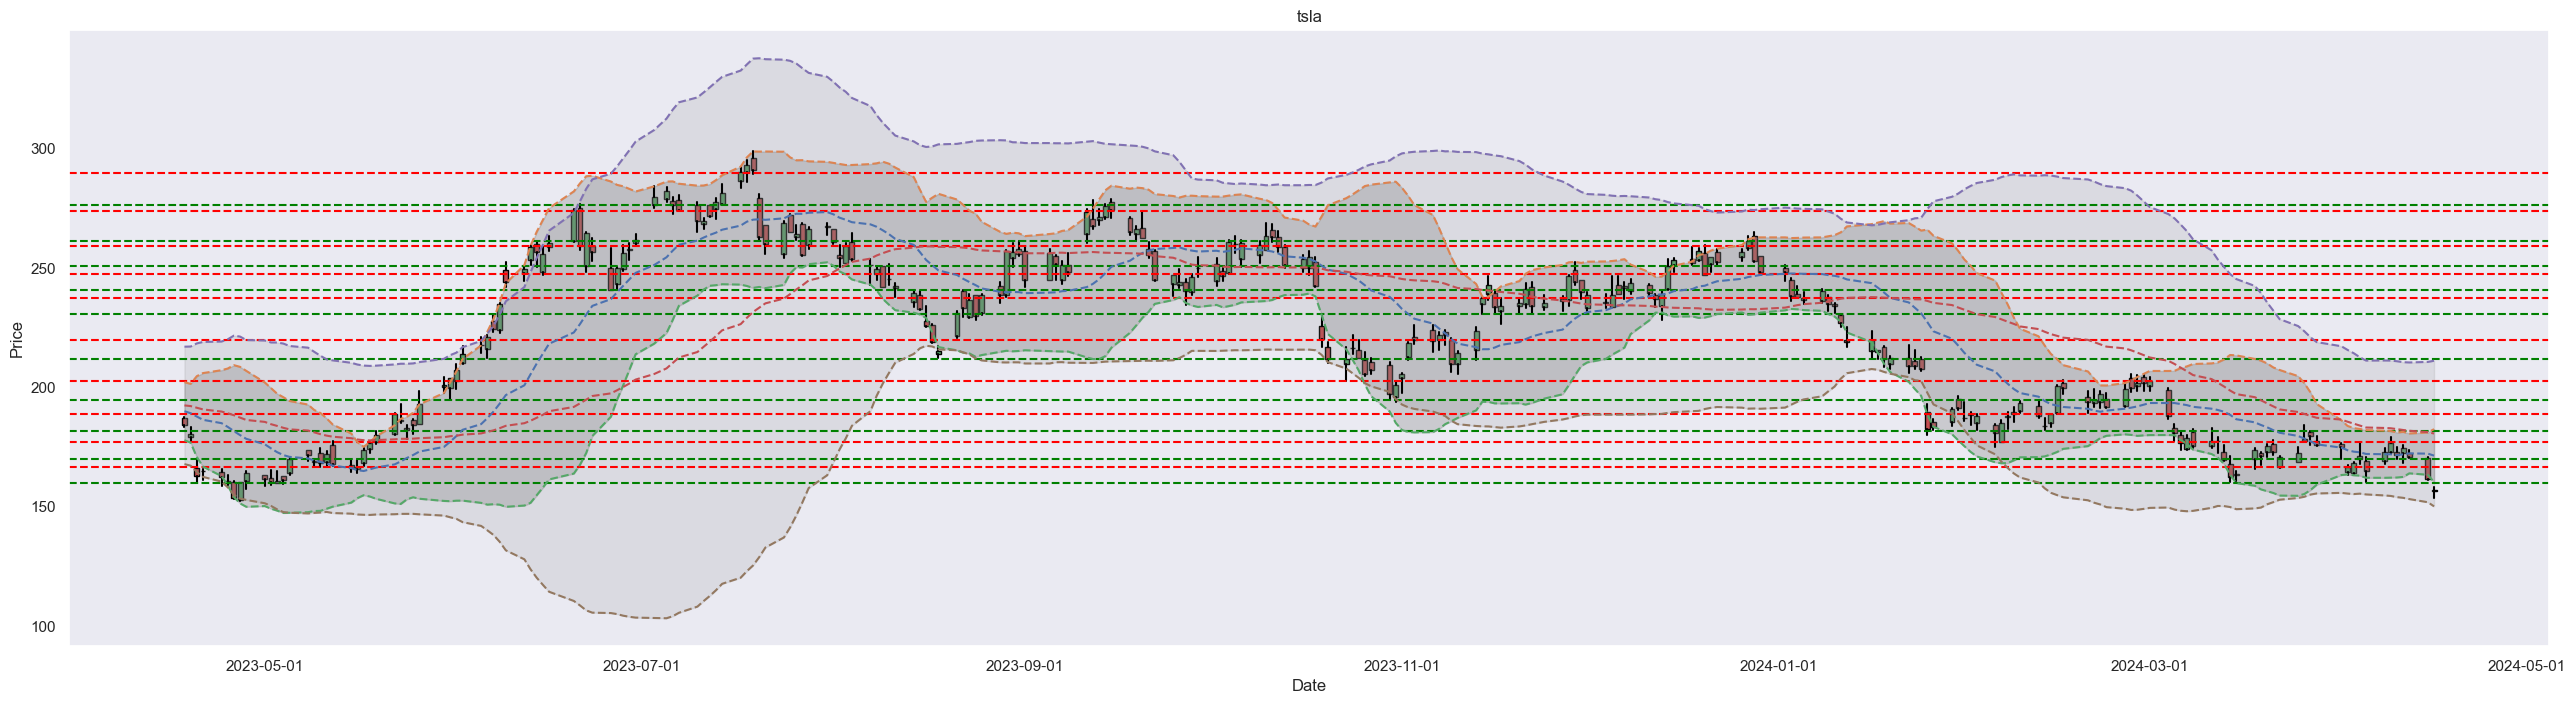

In [14]:
test_option_trading('tsla')

In [15]:
def test_option_trading_fbtc(
                        start=(datetime.today() - relativedelta(years=2)).strftime('%Y-%m-%d'),
                        end=datetime.today().strftime('%Y-%m-%d')
                       ):
    df = yf.download('BTC-USD', start=start, end=end)
    df = df.reset_index()
    df_fbtc = yf.download('fbtc', start=start, end=end)
    df_fbtc = df_fbtc.reset_index()
    
    print(datetime.today().strftime('%Y-%m-%d'))

    df_merged = pd.merge(df[['Date','Open','High', 'Low','Close']],
                  df_fbtc[['Date','Open','High', 'Low','Close']],
                  on='Date')
    s1 = df_merged['Close_x']
    s2 = df_merged['Close_y']
    X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)
    # print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
    # print("Regression coeffs:", theta_best[0], theta_best[1])
    df['Close'] = theta_best[0] + theta_best[1]*df['Close']

    s1 = df_merged['Open_x']
    s2 = df_merged['Open_y']
    X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)
    # print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
    # print("Regression coeffs:", theta_best[0], theta_best[1])
    df['Open'] = theta_best[0] + theta_best[1]*df['Open']

    s1 = df_merged['Low_x']
    s2 = df_merged['Low_y']
    X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)
    # print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
    # print("Regression coeffs:", theta_best[0], theta_best[1])
    df['Low'] = theta_best[0] + theta_best[1]*df['Low']

    s1 = df_merged['High_x']
    s2 = df_merged['High_y']
    X_b = np.c_[np.ones((len(s1), 1)), s1]  # Add a bias term (intercept) to feature matrix
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(s2)
    # print("Correlation and R2:", s1.corr(s2), r2_score(s2, intercept+slope*s1))
    # print("Regression coeffs:", theta_best[0], theta_best[1])
    df['High'] = theta_best[0] + theta_best[1]*df['High']

    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['50 Day MA'] = df['Close'].rolling(window=50).mean()
    df['50 Day STD'] = df['Close'].rolling(window=50).std()    
    # Calculate upper and lower bands
    df['Upper Band - 20MA'] = df['20 Day MA'] + (df['20 Day STD'] * 2)
    df['Lower Band - 20MA'] = df['20 Day MA'] - (df['20 Day STD'] * 2)
    df['Upper Band - 50MA'] = df['50 Day MA'] + (df['50 Day STD'] * 2.5)
    df['Lower Band - 50MA'] = df['50 Day MA'] - (df['50 Day STD'] * 2.5)
    df_plot = df[df['Date'] >= df['Date'].min() + relativedelta(years=1)]

    low_clusters = get_optimum_clusters(df_plot[(df_plot['Low']!=df_plot['Open'])&(df_plot['Low']!=df_plot['Close'])][['Date',"Low"]].set_index('Date'))
    # low_clusters = get_optimum_clusters(df_plot[['Date',"Low"]].set_index('Date'))
    low_centers = low_clusters.cluster_centers_
    low_centers = np.sort(low_centers, axis=0)

    high_clusters = get_optimum_clusters(df_plot[(df_plot['High']!=df_plot['Open'])&(df_plot['High']!=df_plot['Close'])][['Date',"High"]].set_index('Date'))
    # high_clusters = get_optimum_clusters(df_plot[['Date',"High"]].set_index('Date'))
    high_centers = high_clusters.cluster_centers_
    high_centers = np.sort(high_centers, axis=0)
    
    close = df_plot.iloc[-1]['Close']
    try: 
        support = max([e[0] for e in low_centers if e < close])
    except:
        print('Break all support; record min stock price')
        support = df_plot['Low'].min()
    try:
        resistance = min([e[0] for e in high_centers if e > close])
    except:
        print('Break all resistance; record max stock price')
        resistance = df_plot['High'].max()


    close = df_plot.iloc[-1]['Close']
    print('* previous stock price closing', round(close,2), '~ up', ceil(resistance*100)/100.0, ', down', floor(support*100)/100)
    print("Latest 20 Day MA:", df_plot['20 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band, 20MA:", df_plot['Lower Band - 20MA'].tolist()[-1])
    print("Latest Higher Bollinger Band, 20MA:", df_plot['Upper Band - 20MA'].tolist()[-1])
    print("Latest 50 Day MA:", df_plot['50 Day MA'].tolist()[-1])
    print("Latest Lower Bollinger Band, 50MA:", df_plot['Lower Band - 50MA'].tolist()[-1])
    print("Latest Higher Bollinger Band, 50MA:", df_plot['Upper Band - 50MA'].tolist()[-1])    
    
    print(low_centers)
    print(high_centers)

    ax = plot_candlestick(df_plot, figsize=(32,8))
    ax.set_title('FBTC')
    for low in low_centers[:]:
        ax.axhline(low[0], color='green', ls='--')

    for high in high_centers[:]:
        ax.axhline(high[0], color='red', ls='--')
    # df_plot['5_MA'] = df_plot['Close'].rolling(window=5).mean()
    # df_plot['9_MA'] = df_plot['Close'].rolling(window=9).mean()
    # df_plot['20_MA'] = df_plot['Close'].rolling(window=20).mean()
    # df_plot['50_MA'] = df_plot['Close'].rolling(window=50).mean()

    # ax.plot(df_plot['Date'], df_plot['Close'], color='black')
    # ax.plot(df_plot['Date'], df_plot['5_MA'], ls='--')

    # ax.plot(df_plot['Date'], df_plot['9_MA'], ls='--')
    # ax.plot(df_plot['Date'], df_plot['20_MA'], ls='--')
    # ax.plot(df_plot['Date'], df_plot['50_MA'], ls='--')
    ax.plot(df_plot['Date'], df_plot['20 Day MA'], ls='--', label='20 Day Moving Average')
    ax.plot(df_plot['Date'], df_plot['Upper Band - 20MA'], ls='--', label='Upper Bollinger Band, 20MA')
    ax.plot(df_plot['Date'], df_plot['Lower Band - 20MA'], ls='--', label='Lower Bollinger Band, 20MA')
    ax.fill_between(df_plot['Date'], df_plot['Upper Band - 20MA'], df_plot['Lower Band - 20MA'], color='gray', alpha=0.3) # Fill the area between the bands
    ax.plot(df_plot['Date'], df_plot['50 Day MA'], ls='--', label='50 Day Moving Average')
    ax.plot(df_plot['Date'], df_plot['Upper Band - 50MA'], ls='--', label='Upper Bollinger Band, 50MA')
    ax.plot(df_plot['Date'], df_plot['Lower Band - 50MA'], ls='--', label='Lower Bollinger Band, 50MA')
    ax.fill_between(df_plot['Date'], df_plot['Upper Band - 50MA'], df_plot['Lower Band - 50MA'], color='gray', alpha=0.15) # Fill the area between the bands


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
2024-04-17
* previous stock price closing 55.74 ~ up 55.9 , down 54.35
Latest 20 Day MA: 59.4985863193588
Latest Lower Bollinger Band, 20MA: 54.99219165545301
Latest Higher Bollinger Band, 20MA: 64.00498098326459
Latest 50 Day MA: 58.696776940360394
Latest Lower Bollinger Band, 50MA: 51.29652254966263
Latest Higher Bollinger Band, 50MA: 66.09703133105816
[[14.60445597]
 [17.35218602]
 [20.04535811]
 [23.35854473]
 [25.87020617]
 [32.29146   ]
 [36.97096522]
 [43.01454068]
 [54.35620626]
 [59.62706219]]
[[15.7077502 ]
 [18.66182823]
 [21.33500446]
 [24.4255867 ]
 [26.92946856]
 [33.47342213]
 [37.97703142]
 [43.25269127]
 [55.89492038]
 [61.07924634]]


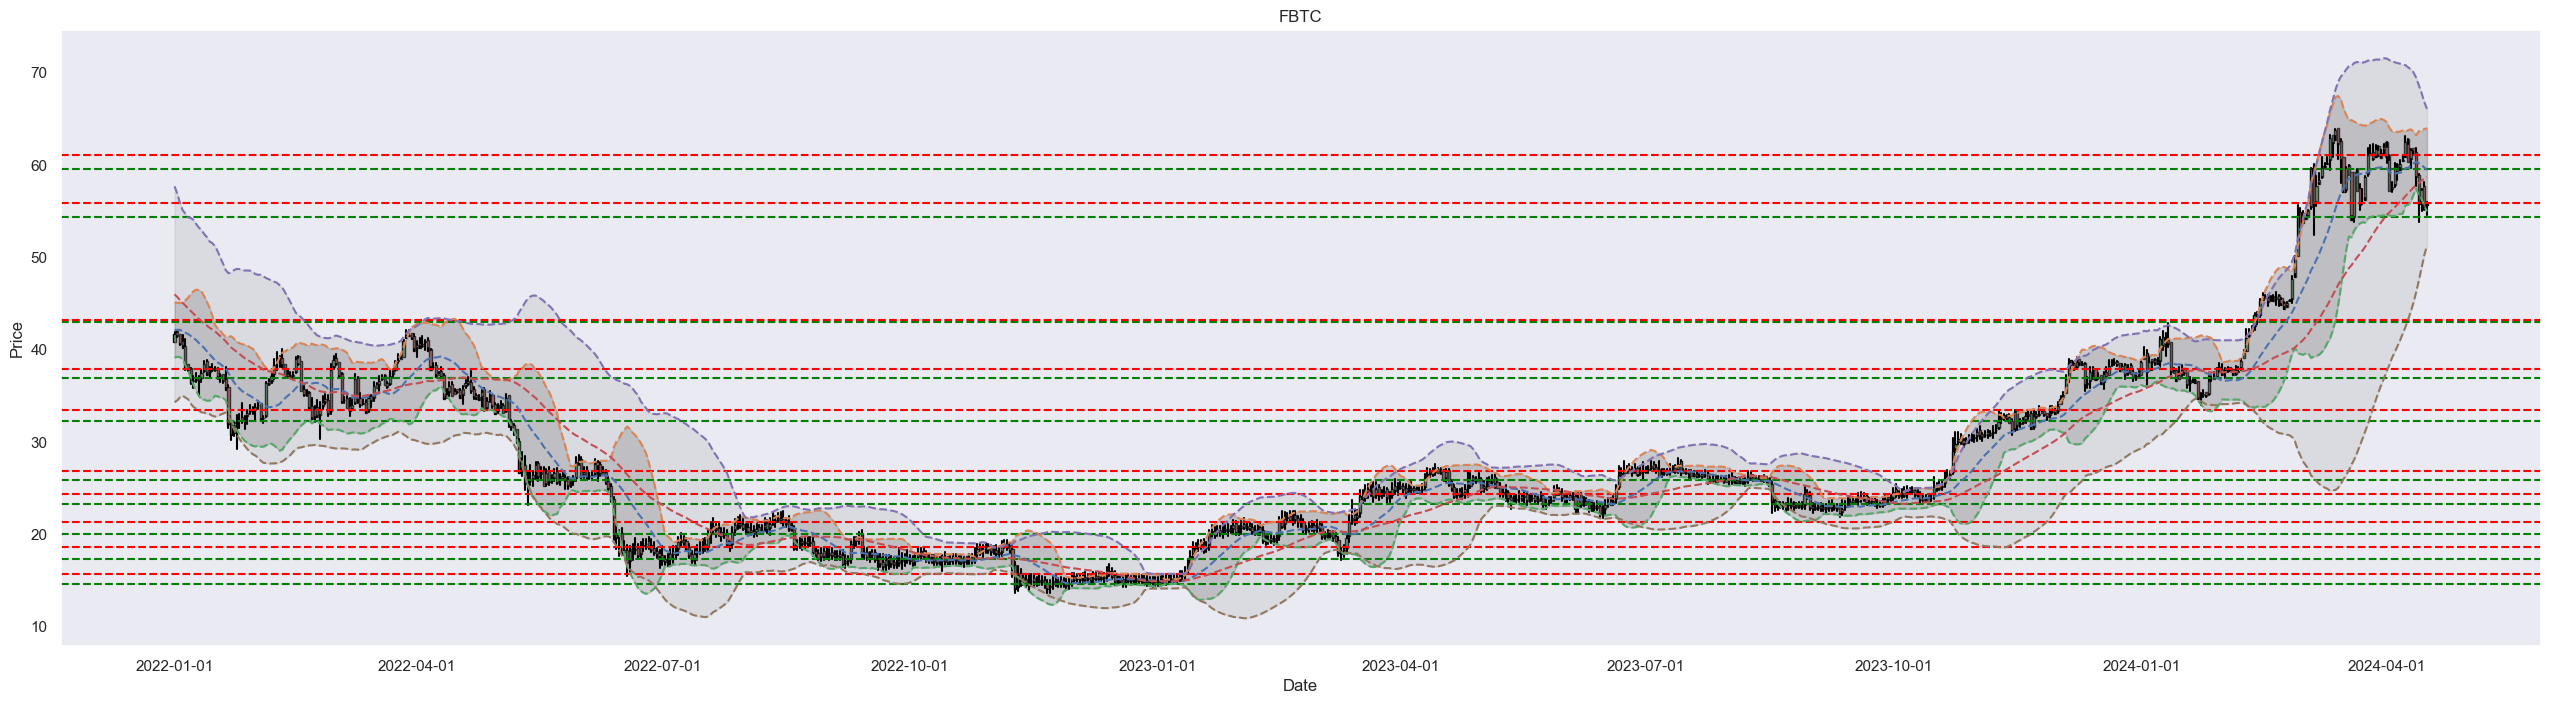

In [16]:
test_option_trading_fbtc(start='2021-01-01')